# Goal: 
### To find a flaring area for the SECOND microflare duringFOXSI2 observations.

Athiray considered Target5 Pos 0 (Target J) - 19:18:51 to 19:19:23 for this study. For variance calculation in Fe18 map use this time interval. Consider the region in the map around microflare-2 say xrange = [-110,-10], yrange=[50,150].
The centroid of this flare accoriding to the FOXSI repository is [-70,90]


### Packages:

In [1]:
import glob
from sunpy.map import Map
from sunpy.time import TimeRange
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.dates as md
import matplotlib as mpl
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
from matplotlib.colors import ListedColormap
import numpy as np
import ipywidgets as widgets
%matplotlib inline
from ndcube import NDCube, NDCubeSequence
from sunpy import cm
from scipy import ndimage

/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### FOXSI2 Targets

In [2]:
Ftarget = {'cen1_pos0':(359.0, -431.0), # arcsec
           'cen1_pos1':(-1.0, -431.0),
           'cen1_pos2':(-1.0, -251.0),
           'cen2_pos0':(-1.0, -281.0),
           'cen2_pos1':(-390.0, -281.0),
           'cen3_pos0':(1210.5, -431.5),
           'cen3_pos1':(850.0, -431.5),
           'cen3_pos2':(850.0, -251.0),
           'cen4':(200.0, 750.0),
           'cen5':(0.0, -251.0),
           'cen_Iris':(11,-260),
           'athiray':(30,-220),
           'athiray2':(-60,100)}
Ftimes = {'cen1_pos0': TimeRange(['2014-12-11 19:12:42', '2014-12-11 19:13:14.3']),
            'cen1_pos1':TimeRange(['2014-12-11 19:13:18','2014-12-11 19:13:42.6']),
            'cen1_pos2':TimeRange(['2014-12-11 19:13:46.5','2014-12-11 19:14:25']),
            'cen2_pos0':TimeRange(['2014-12-11 19:14:29','2014-12-11 19:14:39.6']),
            'cen2_pos1':TimeRange(['2014-12-11 19:14:44','2014-12-11 19:15:36.7']),
            'cen3_pos0':TimeRange(['2014-12-11 19:15:40.6','2014-12-11 19:16:07.2']),
            'cen3_pos1':TimeRange(['2014-12-11 19:16:11','2014-12-11 19:16:30.1']),
            'cen3_pos2':TimeRange(['2014-12-11 19:16:34','2014-12-11 19:17:09.2']),
            'cen4':TimeRange(['2014-12-11 19:17:13.5','2014-12-11 19:18:46.2']),
            'cen5':TimeRange(['2014-12-11 19:18:50.5','2014-12-11 19:19:23.2']),
            't_shtr':TimeRange(['2014-12-11 19:18:18','2014-12-11 19:18:22']),
            'Iris_Obs':TimeRange(['2014-12-11 19:12:22','2014-12-11 19:39:01'])}
fov = (1000,1000) # arcsec
athirayfov = [150,150] #arcsec
athirayfov2 = [100,100] #arcsec

### Reading AIA Data

In [3]:
data_dir = '/Volumes/Pandora/FOXSI/AIA/'
str_indices = {'94':'', '131':'', '171':'', '193':'', '211':'', '304':'', '335':'', '1600':'', '1700':''}
file_list = {}
for key in str_indices:
    file_list.update({key: glob.glob(data_dir + '*' + key + '*.fits')})
    file_list[key]=sorted(file_list[key])

### FeXVIII Full Disk Image

In [4]:
fd094 = Map(file_list['94'][94])
fd171 = Map(file_list['171'][94])
fd211 = Map(file_list['211'][94])
fd = Map(file_list['171'][94])
fd.data[:] = fd094.data - fd211.data[:]/120 - fd171.data[:]/450

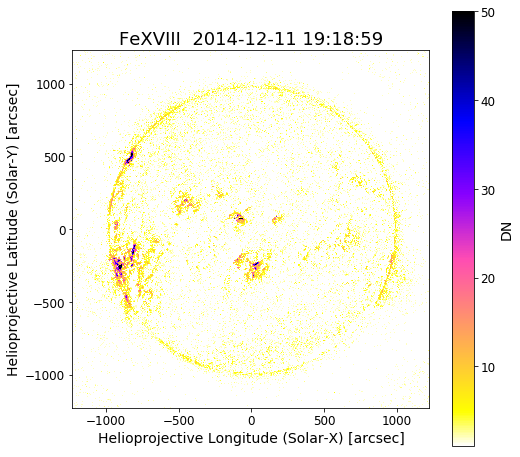

In [5]:
''' Plot '''
fig, ax = plt.subplots(figsize=(8,8));
fd.plot_settings['norm'] = colors.Normalize()
fd.plot(cmap='gnuplot2_r',vmin=1,vmax=50)
plt.title('FeXVIII '+fd.name[-20:],fontsize=18);plt.colorbar(label=fd.meta['pixlunit'])

### Co-Rotating Data

In [6]:
F_AIA094 = file_list['94']
F_AIA171 = file_list['171']
F_AIA211 = file_list['211']

#F_AIA171 = file_list['171'][52:83]
#F_AIA211 = file_list['211'][56:87]
mapsFe18 = []

for f094, f171, f211 in zip(F_AIA094,F_AIA171,F_AIA211):
    m094  = Map(f094)
    m171  = Map(f171)
    m211  = Map(f211)
    mFe18 = Map(f171)
    mFe18.data[:] = m094.data - m211.data[:]/120 - m171.data[:]/450
    ## Co-rotating maps:
    top_right =   SkyCoord((Ftarget['athiray2'][0] + athirayfov2[0]/2) * u.arcsec, 
                           (Ftarget['athiray2'][1] + athirayfov2[1]/2) * u.arcsec, frame=mFe18.coordinate_frame)
    bottom_left = SkyCoord((Ftarget['athiray2'][0] - athirayfov2[0]/2) * u.arcsec, 
                           (Ftarget['athiray2'][1] - athirayfov2[1]/2) * u.arcsec,frame=mFe18.coordinate_frame)
    submap = mFe18.submap(bottom_left, top_right)
    mapsFe18.append(submap)    

### FeXVIII Movie

In [7]:
def allfov(t):
#for t in range (93-l,96+l): 
    fig, ax = plt.subplots(figsize=(10,10));
    mapsFe18[t].plot_settings['norm'] = colors.Normalize()
    mapsFe18[t].plot(vmin=10,vmax=200,cmap='gnuplot2_r',title='FeXVIII    '+F_AIA171[t][41:63])
    plt.colorbar()
    #plt.savefig('/Users/Kamilobu/Desktop/temporal/FeXVIII'+str(t)+'.png')

In [8]:
l = 12; 
widgets.interact(allfov, t=(93-l,96+l));

interactive(children=(IntSlider(value=94, description='t', max=108, min=81), Output()), _dom_classes=('widget-…

### Running Differences

In [9]:
import copy
diff = copy.deepcopy(mapsFe18)
for d in range (1,len(diff[1:])):
    diff[d].data[:] = mapsFe18[d].data[:] - mapsFe18[d-1].data[:]

In [10]:
def difffov(t):
#for t in range (93-l,96+l): 
    fig, ax = plt.subplots(figsize=(10,10));
    diff[t].plot(cmap='gnuplot2_r',title='FeXVIII    '+F_AIA171[t][41:63],vmin=0,vmax=60)
    plt.colorbar()
    #plt.savefig('/Users/Kamilobu/Desktop/temporal/FeXVIII'+str(t)+'.png')

In [11]:
l = 12;
widgets.interact(difffov, t=(93-l,96+l));

interactive(children=(IntSlider(value=94, description='t', max=108, min=81), Output()), _dom_classes=('widget-…

### Standard Deviation

In [12]:
def std(cmaps):
    """
    Calculate the standard deviation of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.std(data, axis=2), _meta[1])

In [13]:
## Standard Deviation:
l = 12;
maps = mapsFe18[93-l:96+l]
stdmap = std(maps)

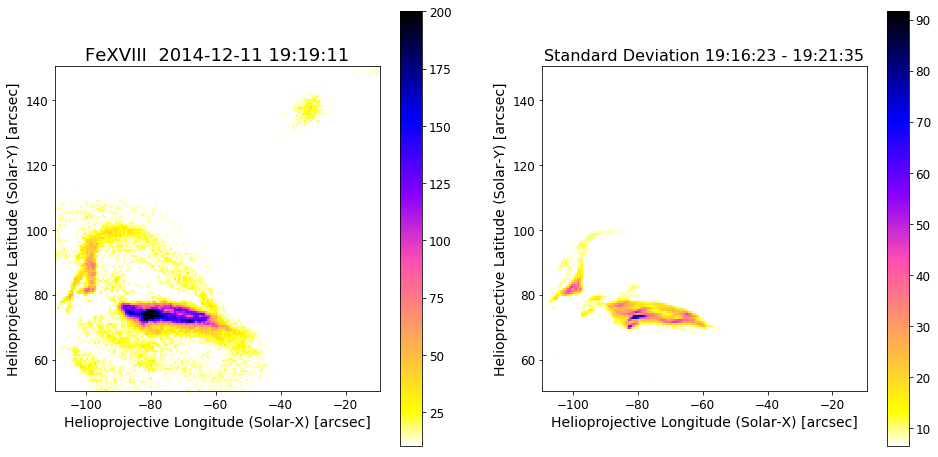

In [14]:
ta = 14
'''Plotting'''
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
maps[ta].plot_settings['norm'] = colors.Normalize()
maps[ta].plot(cmap='gnuplot2_r',vmin=10,vmax=200)
plt.title('FeXVIII '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
plt.subplot(1,2,2)
stdmap.plot_settings['norm'] = colors.Normalize()
stdmap.plot(vmin=0.07*stdmap.data.max(),cmap='gnuplot2_r')
plt.title('Standard Deviation '+maps[0].name[-8:]+' - '+maps[-1].name[-8:],fontsize=16);plt.colorbar()
plt.show()

### Sunpy find bright points

#### Maks Quicklook

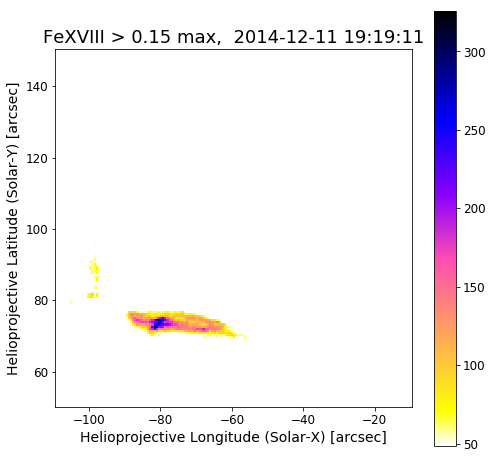

In [15]:
MaskRatio = 0.15
data_max = maps[ta].max()
mask = maps[ta].data > data_max * MaskRatio
#maps[ta].mask = mask
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
maps[ta].plot_settings['norm'] = colors.Normalize()
maps[ta].plot(cmap='gnuplot2_r',vmin=data_max * MaskRatio)
plt.title('FeXVIII > '+str(MaskRatio)+' max, '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
plt.show()

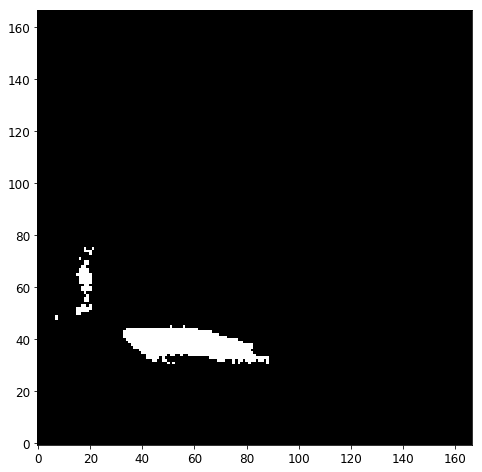

In [16]:
plt.figure(figsize=(8,8))
mask = maps[ta].data < data_max * MaskRatio
plt.imshow(mask,origin='lower',cmap='Greys')

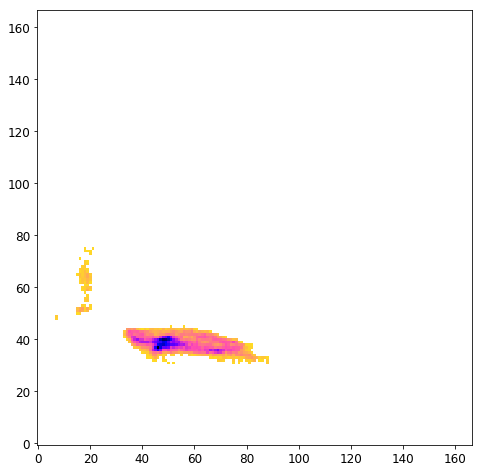

In [17]:
data2 = ndimage.gaussian_filter(maps[ta].data * ~mask, 0)
plt.figure(figsize=(8,8))
plt.imshow(data2,origin='lower',cmap='gnuplot2_r')

### Sunpy regions over the image maximum

In [18]:
map15 = copy.deepcopy(maps[ta])
map15.data[np.where(map15.data < (map15.data.max()*0.15))] = 0.0
data2 = ndimage.gaussian_filter(map15.data * ~mask, 1)
aiamap2 = Map(data2, map15.meta)
labels, n = ndimage.label(aiamap2.data)

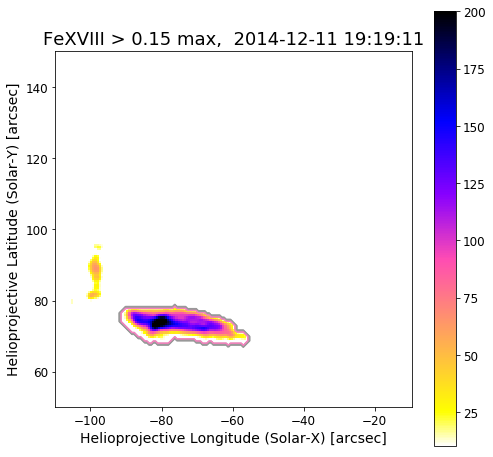

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
aiamap2.plot_settings['norm'] = colors.Normalize()
aiamap2.plot(cmap='gnuplot2_r',vmin=10,vmax=200)
plt.title('FeXVIII > '+str(MaskRatio)+' max, '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
extent = (Ftarget['athiray2'][0]-athirayfov2[0]/2,Ftarget['athiray2'][0]+athirayfov2[0]/2,
          Ftarget['athiray2'][1]-athirayfov2[1]/2,Ftarget['athiray2'][1]+athirayfov2[1]/2)
plt.contour((labels==1),extent=extent,cmap='Set1_r',vmin=0,vmax=8)
#plt.figtext(0.3, 0.2, 'Number of regions = {}'.format(n), color='blue')
plt.show()

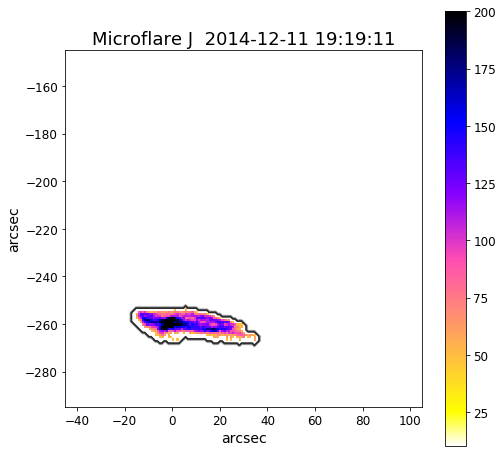

In [20]:
data3 = ndimage.gaussian_filter(map15.data * (labels==1), 0)
plt.figure(figsize=(8,8))
extent = (-45,105,-295,-145)
plt.title('Microflare J '+maps[ta].name[-20:],fontsize=18)
plt.imshow(data3,origin='lower',cmap='gnuplot2_r',vmin=10,vmax=200,extent=extent)
plt.colorbar()
plt.xlabel('arcsec');plt.ylabel('arcsec');
plt.contour(((labels==1)),extent=extent,cmap='Greys')

## Time evolution

In [21]:
'''Time range'''
atime, lcrb1 = [],[]
for m in maps:
    atime.append(str(m.meta['t_obs'][:-1]))
    lcrb1.append((m.data * (labels == 1)).sum())
atime = np.array(atime,dtype='datetime64[ms]')
atmax = np.array(['2014-12-11T19:18:50','2014-12-11T19:19:23'],dtype='datetime64[ms]')
xfmt = md.DateFormatter('%H:%M:%S')

/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


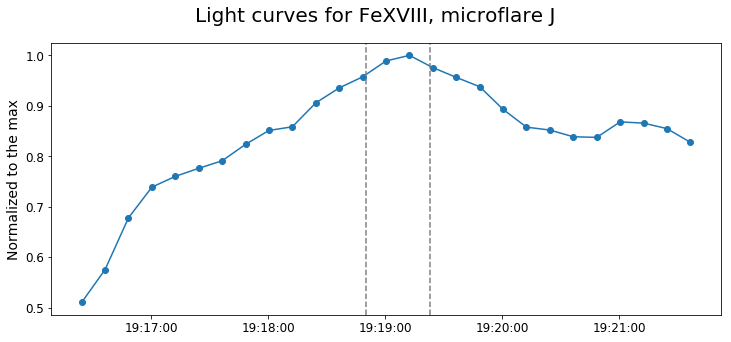

Microflare J size [pxs] =  773


In [22]:
fig, ax1 = plt.subplots(figsize=(12,5))
fig.suptitle('Light curves for FeXVIII, microflare J',fontsize=20)
ax1.plot(atime,np.abs(lcrb1)/np.abs(max(lcrb1)),'o-')
ax1.axvline(x=atmax[0],linestyle='--',color='grey')
ax1.axvline(x=atmax[1],linestyle='--',color='grey')
ax1.set_ylabel('Normalized to the max')
ax1.xaxis.set_major_formatter(xfmt)
plt.show()
print('Microflare J size [pxs] =  '+str(len(labels[labels == 1])))

In [23]:
aux = maps[ta].data[np.where(maps[ta].data > (np.max(maps[ta].data.all())*0.15))]

In [25]:
import pandas as pd

df = pd.DataFrame({"time" : atime, "FeXVIII" : np.abs(lcrb1)/np.abs(max(lcrb1))})
df.to_csv("MicroflareJ_FeZVIII.csv", index=False)
